263
xgb

## 必要なライブラリのimport

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle

pd.set_option('display.max_columns', 500)

In [3]:
# 予測したいデータの読み込み

path_test = '../../../../data/extornal/test_processed_clv&churn.csv'

test_all = pd.read_csv(path_test)

# 特徴量の選択
features_all = pd.read_csv('../../../../data/processed/features_52_all.csv')


In [4]:


pct25 = features_all['importance'].quantile(0.25)

features_selected = features_all.query('importance > @pct25').reset_index(drop=True)
selected_columns = features_selected['feature'].tolist()
selected_columns.insert(0,'card_id')
test = test_all[selected_columns]


In [6]:
# 前処理コードの追加
def preprocess_data(data):
    # infを適切な最大値または最小値に置き換え
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # NaNを各列の中央値に置き換え
    for column in data.columns:
        if data[column].isnull().any():
            median_value = data[column].median()
            data[column].fillna(median_value, inplace=True)
    
    return data

# trainデータの前処理
test = preprocess_data(test)

C:\Users\kakeru.oshikiri.bt\AppData\Local\Temp\ipykernel_8448\737443088.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(median_value, inplace=True)
C:\Users\kakeru.oshikiri.bt\AppData\Local\Temp\ipykernel_8448\737443088.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

card_id                       0
total_date_min                0
new_frequency_rmf             0
new_purchase_amount_mean      0
new_transactions_count        0
                             ..
total_date_max                0
new_purchase_month_mean       0
ratio_merchant_category_nu    0
auth_month_diff_mean          0
new_purchase_amount_sum       0
Length: 249, dtype: int64

## 保存されたモデルを使って予測を行う

In [10]:
n_folds = 5
predictions = np.zeros(len(test))
features = [c for c in test.columns if c not in ['card_id',]]


for fold_ in range(n_folds):
    # モデルを読み込む
    with open(f'../src/models/xgb_62/model_fold_{fold_}.pkl', 'rb') as f:
        clf = pickle.load(f)
    # モデルで予測を行う
    #fold_predictions = clf.predict(test[features])
    fold_predictions = clf.predict(xgb.DMatrix(test[features]))
    # 予測結果を足し合わせる
    predictions += fold_predictions

# 平均を取る
predictions /= n_folds

# RMSEを計算する（テストデータに対して真の値がある場合）
# y_testが存在する場合に限り
if 'y_test' in locals():
    score = mean_squared_error(y_test, predictions, squared=False)
    print(f'RMSE={score}')

In [11]:
# 予測結果を出力する
print(predictions)

[-4.09831181 -0.25886032 -1.39049981 ...  0.76908388 -4.44479809
  0.07979837]


## 提出用ファイルの作成

In [12]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submit_oshikiri_62.csv", index=False)

(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00,
        3.0000e+00, 6.0000e+00, 1.2000e+01, 5.0000e+00, 1.2000e+01,
        8.0000e+00, 7.0000e+00, 5.0000e+00, 1.7000e+01, 1.0000e+01,
        1.3000e+01, 1.2000e+01, 1.2000e+01, 2.2000e+01, 1.6000e+01,
        1.4000e+01, 1.5000e+01, 1.7000e+01, 2.1000e+01, 1.5000e+01,
        2.2000e+01, 2.7000e+01, 2.8000e+01, 2.6000e+01, 2.4000e+01,
        3.1000e+01, 3.1000e+01, 4.3000e+01, 2.5000e+01, 3.9000e+01,
        3.4000e+01, 4.1000e+01, 4.6000e+01, 4.1000e+01, 5.2000e+01,
        5.8000e+01, 7.8000e+01, 6.3000e+01, 7.8000e+01, 8.5000e+01,
        8.1000e+01, 1.0200e+02, 1.2700e+02, 1.2500e+02, 1.4500e+02,
        1.6400e+02, 1.9400e+02, 2.2500e+02, 2.7900e+02, 2.8800e+02,
        3.7700e+02, 4.5000e+02, 4.9700e+02, 6.5100e+02, 7.7900e+02,
        9.3200e+02, 1.2290e+03, 1.5690e+03, 1.95

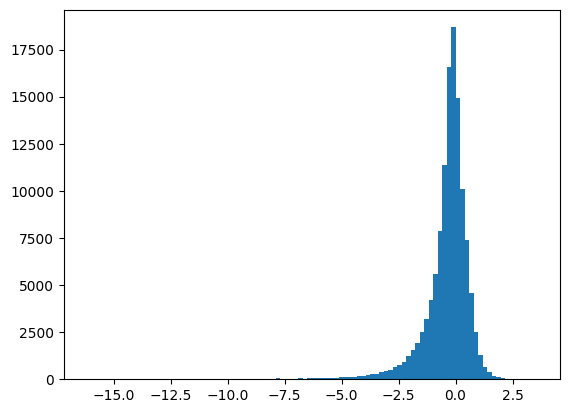

In [13]:
import matplotlib.pyplot as plt
#plt.yscale('log')
plt.hist(sub_df.target, bins=100)
#plt.hist(predictions[predictions<0], bins=100)

In [19]:
sub_df

,card_id,target
0,C_ID_0ab67a22ab,-2.072153
1,C_ID_130fd0cbdd,-0.191818
2,C_ID_b709037bc5,-0.591274
3,C_ID_d27d835a9f,-0.176060
4,C_ID_2b5e3df5c2,-0.980048
...,...,...
123618,C_ID_7a239d2eda,0.800503
123619,C_ID_75ace375ae,-0.307557
123620,C_ID_21d56d950c,1.001854
123621,C_ID_6c46fc5a9d,-2.995060


In [10]:
test

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,...,total_duration_min,total_duration_max,total_duration_mean,total_amount_month_ratio_min,total_amount_month_ratio_max,total_amount_month_ratio_mean,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu
0,1978,C_ID_0ab67a22ab,3,3,1,306,2,918,918,306,...,158.0,51666.0,7779.549296,0.025316,8.278481,1.250920,330,0.045998,1.042612,0.187500
1,1888,C_ID_130fd0cbdd,2,3,0,396,1,792,1188,0,...,308.0,54593.0,5825.022989,0.051948,9.207792,0.982607,462,0.085422,0.740325,0.500000
2,2100,C_ID_b709037bc5,5,1,1,184,3,920,184,184,...,1155.0,167706.0,54367.133333,0.194805,28.285714,9.169697,199,0.117430,0.763294,0.250000
3,2222,C_ID_d27d835a9f,2,1,0,62,4,124,62,0,...,770.0,42812.0,10590.388889,0.129870,7.220779,1.793936,134,0.300996,0.782590,0.555556
4,1491,C_ID_2b5e3df5c2,5,1,1,793,4,3965,793,793,...,0.0,847000.0,54698.353448,0.000000,142.857143,9.229007,464,0.154201,2.827010,0.161290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2161,C_ID_7a239d2eda,2,2,0,123,4,246,246,0,...,770.0,11172.0,3575.301370,0.129870,1.934211,0.607829,134,0.000000,0.000000,0.000000
123619,2131,C_ID_75ace375ae,3,1,1,153,3,459,153,153,...,308.0,10780.0,2995.363636,0.051948,1.818182,0.505422,206,1.047847,1.833732,1.000000
123620,1766,C_ID_21d56d950c,5,1,1,518,3,2590,518,518,...,2464.0,123585.0,29135.972973,0.415584,20.844156,4.922341,305,0.000000,0.000000,0.000000
123621,2039,C_ID_6c46fc5a9d,2,1,0,245,2,490,245,0,...,486.0,34020.0,6241.794118,0.074074,5.185185,0.953531,177,0.097719,1.009765,0.333333
